> Code to accompany **Chapter 10: Defending Against Adversarial Inputs**

# Fashion-MNIST - Dropout for Adversarial Detection

In this notebook, we'll create a classifier that uses drop-out during test as well as training time. This introduces
uncertainty to the network's predictions so each time an image is passed to the network, it will generated a slightly 
different answer.

Adding uncertainty to test time may result in reduced accuracy. However, the point of a model of this type is to distinguish adversarial from non-adversarial. Therefore, it might run alongside another model during operations. 

In theory, the uncertainty (variation) in the answers for a particular image will be greater when an image is not 
within the training data set distribution. Refer to  __Chapter 10__ for a more detailed discussion.

In [1]:
import tensorflow as tf
from tensorflow import keras
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images/255.0
test_images = test_images/255.0

## Create a Simple Network with drop-out for Image Classification

We need to use the Keras __functional API__ (rather than the sequential API) to access the 
dropout capability with `training = True` at test time. 

You can experiment by moving the drop-out layer or the level of dropout.

In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(28,28))
x = Flatten()(inputs)
x = Dense(56, activation='relu')(x)
x = Dropout(0.2)(x, training=True)
x = Dense(56, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 56)                43960     
_________________________________________________________________
dropout (Dropout)            (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3192      
_________________________________________________________________
dense_2 (Dense)      

In [3]:
model.fit(train_images, train_labels, epochs=12)

Epoch 1/12
60000/60000 [==============================] - 4s 64us/sample - loss: 0.5756 - acc: 0.7952
Epoch 2/12
60000/60000 [==============================] - 4s 61us/sample - loss: 0.4342 - acc: 0.8414
Epoch 3/12
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3975 - acc: 0.8535
Epoch 4/12
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3808 - acc: 0.8600
Epoch 5/12
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3638 - acc: 0.8654
Epoch 6/12
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3509 - acc: 0.8706
Epoch 7/12
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3425 - acc: 0.8731
Epoch 8/12
60000/60000 [==============================] - 4s 58us/sample - loss: 0.3335 - acc: 0.8771
Epoch 9/12
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3255 - acc: 0.8791
Epoch 10/12
60000/60000 [==============================] - 4s 60us/sample - loss: 

Take a look at the model's accuracy.
This will change due to the uncertainty of the network each time you re-run this cell.

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Model accuracy based on test data:', test_acc)

10000/10000 [==============================] - 0s 48us/sample - loss: 0.3828 - acc: 0.8613
Model accuracy based on test data: 0.8613


## Prepare the data that we will use to test

We'll take two test datasets and check each for its level of uncertainty:
- x_images
- x_images_adv

For the adversarial images, you can use the images generated on the original model and saved in LINK TODO, or the images generated against the drop-out enabled model and saved in LINK TODO. 

In [5]:
import numpy as np
num_images = 1000
x_images = test_images[:num_images]

x_images_adv = np.load('../resources/test_images_GSAttack.npy')[:num_images]    
#x_images_adv = np.load('../resources/test_images_GSAttack_dropout.npy')[:num_images]


Repeatedly call the drop-out model to get its predictions across the batches of images. 
Each time it will return a different set of predictions.

We build up two prediction matrices:

- predictions matrix
- predictions_matrix_adv


In [6]:
L = 100
num_classes = 10

predictions_matrix = np.zeros((L, num_images, num_classes)) 
predictions_matrix_adv = np.zeros((L, num_images, num_classes)) 

for i in range(L):
    predictions = model.predict(x_images)
    predictions_adv = model.predict(x_images_adv)
    predictions_matrix[i] = predictions    
    predictions_matrix_adv[i] = predictions_adv   


## Measuring the uncertainty of the responses

The following method calculates a value representing the level of uncertainty over a set of responses __for a single image__ returned from the network.

\begin{align}
U(x) = (\frac{1}{L}{\sum_{i=1}\|F_r(x)\|}) - 
        \|\frac{1}{L}{\sum_{i=1}F_r(x)}\|
\end{align}

$$\text{where}\:\|y\| = \text{the squared}\: L_2\text{-norm}$$


Reference: https://arxiv.org/abs/1705.07263


In [7]:
def uncertainty(predictions):
    return(np.sum(np.square(predictions))/predictions.shape[0] 
           - np.sum(np.square(np.mean(predictions, axis=0))))  

Calculate the uncertainty for the two image batches.

In [8]:
uncertainty_results = np.zeros((num_images))
uncertainty_results_adv = np.zeros((num_images))

for i in range(num_images):
    uncertainty_results[i] = uncertainty(predictions_matrix[:,i])
    uncertainty_results_adv[i] = uncertainty(predictions_matrix_adv[:,i])

Plot the results

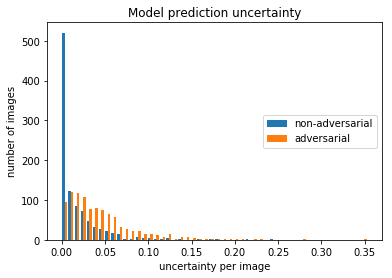

In [11]:
import matplotlib.pyplot as plt

plt.hist((uncertainty_results, uncertainty_results_adv), bins=50, label=('non-adversarial','adversarial'))

plt.title("Model prediction uncertainty")
plt.xlabel("uncertainty per image")
plt.ylabel("number of images")
plt.legend(loc='right')

plt.show()

## Where next?
You can use this notebook to further experiment with randomized dropout, such 
as changing the dropout parameters or altering the attack methods.

Assuming the attacker has complete knowledge of this defence, they might create their adversarial examples using the drop-out network. To see how the uncertainty of the network affects the ability to create adversarial examples, take a look at 
[../chapter10/FashionMNIST_dropout_for_detection.ipynb]().
